In [1]:
## Increase the width of the notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Import Libraries

In [10]:
from fastai.vision.all import *
from assets.chiputility import *
from tqdm import tqdm

%matplotlib inline

### Setup paths

In [3]:
root_path = Path('data')
img_path = root_path / 'train_features'
label_path = root_path / 'train_labels'

In [4]:
df = pd.read_csv(root_path / 'train_final.csv')
chips = Chips(img_path, df)

In [5]:
chip = chips.paths[0]
chips.paths

(#11748) [Path('data/train_features/adwp'),Path('data/train_features/adwu'),Path('data/train_features/adwz'),Path('data/train_features/adxp'),Path('data/train_features/aeaj'),Path('data/train_features/aeap'),Path('data/train_features/aebi'),Path('data/train_features/aebu'),Path('data/train_features/aeej'),Path('data/train_features/aeey')...]

In [6]:
BANDS = ['B02','B03','B04','B08']

In [7]:
## For double checking or separating no/all mask instances
#for chip in tqdm(chips.paths):
#    loc_chip = df['chip_id'] == chip.stem
#    mask = get_mask(chip, label_path)
#    count_mask = mask.sum()
#    pct_mask = count_mask / 512 / 512
#    
#    df.loc[loc_chip, 'count_mask_pxl'] = count_mask
#    df.loc[loc_chip, 'pct_mask_pxl'] = round(pct_mask, 3)

### Load rgb image
Sigmoid contrast enhancment of ms.true_color gives a better image for visual inspection as my own image loading.

In [8]:
import xarray
import xrspatial.multispectral as ms

def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])

def true_color_img(chip):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    red = get_xarray(chip / "B04.tif")
    green = get_xarray(chip / "B03.tif")
    blue = get_xarray(chip / "B02.tif")

    return ms.true_color(r=red, g=green, b=blue)

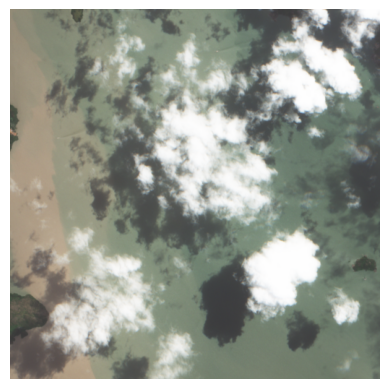

In [9]:
img = true_color_img(chip)
plt.imshow(img)
plt.axis('off')
plt.show()

### Display image data & mask

In [9]:
def display_chip(chip, no_turns = False, smooth = False):
    """
    Loads image data from a chips path, and displays 3 images. Firstly the rgb bands together with the contour of the ground truth mask. Then the binary mask and at last the infrared band (as grayscale) together with the masks contours.
    no_turns: turns the mask by 90 degree for `no_turns` times
    smooth: smoothes the mask and the derived contour
    """
    chip_id = chip.stem
    chip_loc = df.loc[df['chip_id'] == chip_id, 'location'].item()
    
    img = np.asarray(true_color_img(chip))
    img_infra = get_array(chip, 'B08').copy()
    msk = get_mask(chip, label_path)
    if no_turns:
        for _ in range(no_turns):
            msk = np.rot90(msk)
    if smooth:
        pil_msk = Image.fromarray(msk)
        pil_msk_smooth = pil_msk.filter(ImageFilter.ModeFilter(size=5))
        msk = np.array(pil_msk_smooth)
    contour = np.array(Image.fromarray(msk).filter(ImageFilter.FIND_EDGES))
    img[np.where(contour)] = (250.,50.,150.,255.)
    
    fig, ax = plt.subplots(1, 3, figsize=(25, 10))
    ax[0].imshow(img)
    ax[0].set_title(f"Chip {chip_id}\n(Location: {chip_loc})")
    ax[0].axis('off')
    
    ax[1].imshow(msk)
    ax[1].set_title(f"Chip {chip_id} label; min: {msk.min()}, max: {msk.max()}, mean: {msk.mean()}")
    ax[1].axis('off')
    
    img_infra[np.where(contour)] = 0
    ax[2].imshow(img_infra)
    ax[2].set_title(f"Chip {chip_id} infrared band")

    plt.tight_layout()
    plt.show()

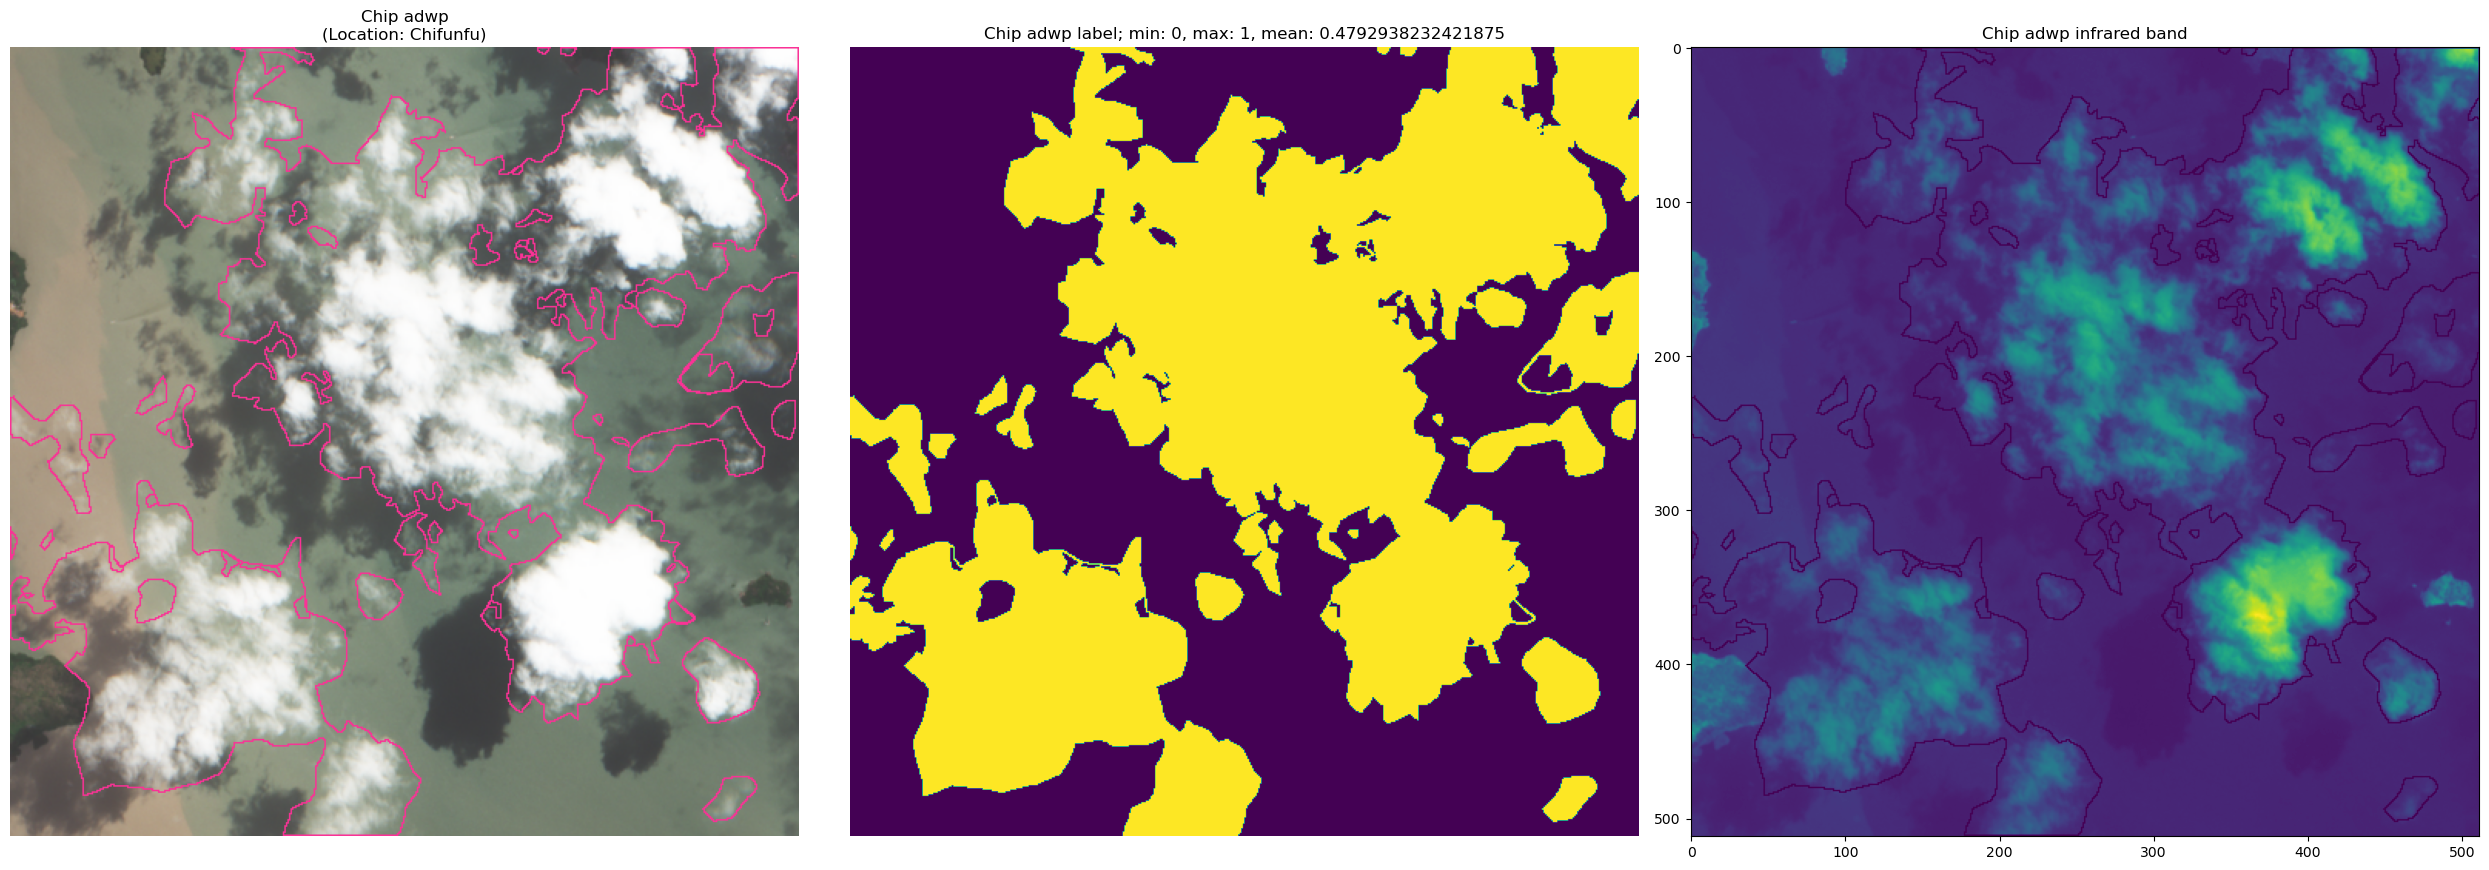

In [13]:
display_chip(chip)

### Go through all images and check if the mask matches the image. If it does not seem to fit, add a coment to a dataframe. Found instances can be removed or further investigated.

In [17]:
trouble_df = pd.DataFrame()

In [14]:
#i = 0

In [4057]:
#i += 1
#chip = chips.paths[i]
#print(i, chip.name)
#display_chip(chip, smooth = False)
#problem = input("What's the problem? ")
#if problem:
#    trouble_df = trouble_df.append({'chip_id': chip.name, 'problem': problem}, ignore_index = True);

## Save the dataframe and the list of chip ids.

In [4055]:
#trouble_df.save(root_path / 'trouble_chips_final.csv')
#np.save(root_path / 'trouble_chips.npy', trouble_df.chip_id.unique())

In [14]:
trouble_df = pd.read_csv(root_path / 'trouble_chips_final.csv', index_col = 0)
trouble_df.head()

,chip_id,problem
0,aehu,first 17 pixels in first row are zero instead of 1
1,agfg,last two rows- between first 150 cols might be 1
2,ahhr,first few columns missing values?
3,aivi,first few rows- first column should be cloud
4,afyr,visual clouds dont fit to mask
